In [9]:
import os

# Change the working directory
os.chdir('C:/Users/IT/Downloads/2023')

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\IT\Downloads\2023


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Step 1: Generate random presence-absence data
np.random.seed(42)
n_samples = 100
presence_absence = np.random.choice([0, 1], size=n_samples)

# Step 2: Generate environmental variables
n_variables = 3
env_variables = np.random.normal(size=(n_samples, n_variables))

# Combine presence-absence data and environmental variables into a DataFrame
data = pd.DataFrame(env_variables, columns=[f'env_var_{i+1}' for i in range(n_variables)])
data['presence_absence'] = presence_absence

In [3]:
data.head()

,env_var_1,env_var_2,env_var_3,presence_absence
0,0.738467,0.171368,-0.115648,0
1,-0.301104,-1.478522,-0.719844,1
2,-0.460639,1.057122,0.343618,0
3,-1.763040,0.324084,-0.385082,0
4,-0.676922,0.611676,1.031000,0


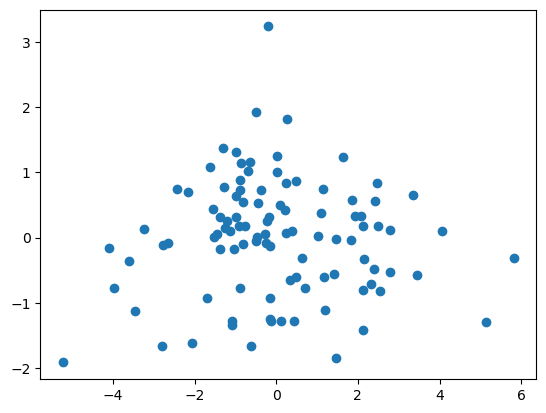

In [6]:
# Step 3: Perform PCA on the environmental variables
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data.iloc[:, :-1])

# Add principal components to the DataFrame
data['PC1'] = principal_components[:, 0]
data['PC2'] = principal_components[:, 1]
plt.scatter(data['PC1'],data['PC2'])
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Principal Component 2')

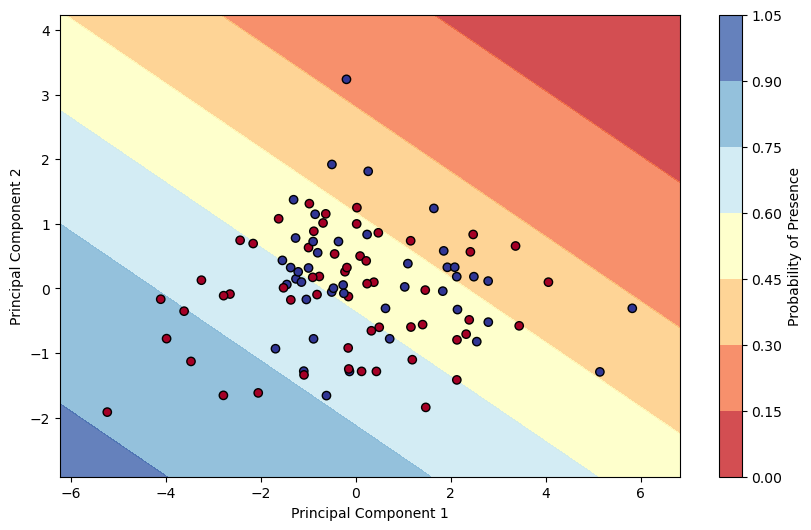

In [7]:
# Step 4: Logistic Regression
X = data[['PC1', 'PC2']]
y = data['presence_absence']
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Step 5: Generate a predicted map
# Create a grid of new environmental variable values
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict presence probabilities over the grid
Z = log_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the predicted map
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.colorbar(label='Probability of Presence')
plt.scatter(data['PC1'], data['PC2'], c=data['presence_absence'], edgecolors='k', cmap=plt.cm.RdYlBu_r)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


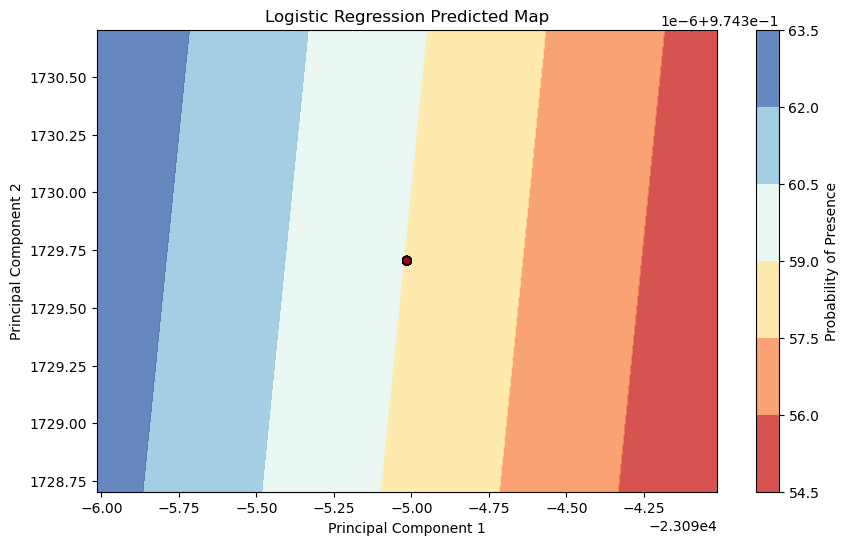

In [12]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from rasterio.mask import mask

# Paths to the Landsat bands
B2 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B2.TIF'
B3 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B3.TIF'
B4 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B4.TIF'
B5 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B5.TIF'
B10 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B10.TIF'
B11 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B11.TIF'

# List of band paths
bands = [B2, B3, B4, B5, B10, B11]

# Path to the shapefile containing Daegu boundary
boundary_shapefile_path = 'Daegu/Daegu.dbf'
points_shapefile_path = 'Daegu_point_korea_127/Daegu_point_korea_127.dbf'

# Read the shapefile using GeoPandas
gdf_boundary = gpd.read_file(boundary_shapefile_path)
gdf_points = gpd.read_file(points_shapefile_path)

# Function to reproject GeoDataFrame to match raster CRS
def reproject_to_match_raster(gdf, raster_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
    return gdf.to_crs(raster_crs)

# Function to clip raster data
def clip_raster_with_shapefile(raster_path, gdf_boundary):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, gdf_boundary.geometry, crop=True)
        out_meta = src.meta
    return out_image, out_transform, out_meta

# Reproject the boundary GeoDataFrame to match the raster CRS
gdf_boundary = reproject_to_match_raster(gdf_boundary, bands[0])
gdf_points = reproject_to_match_raster(gdf_points, bands[0])

# Clip each Landsat band
clipped_data = []
for band in bands:
    clipped_band, transform, meta = clip_raster_with_shapefile(band, gdf_boundary)
    clipped_data.append(clipped_band[0])  # We take the first band assuming it's single-band raster

# Convert clipped data to numpy array
clipped_data = np.array(clipped_data)

# Flatten clipped band values
num_bands, height, width = clipped_data.shape
flattened_data = clipped_data.reshape(num_bands, -1).T

# Perform PCA
pca = PCA(n_components=3)
pca_data = pca.fit_transform(flattened_data)

# Add PCA components to the GeoDataFrame
gdf_points[['PC1', 'PC2', 'PC3']] = pca_data[:len(gdf_points)]

# Prepare data for logistic regression
X = gdf_points[['PC1', 'PC2', 'PC3']]
y = gdf_points['P__bengale']

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)

# Create a grid for new environmental variable values
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
z_min, z_max = X['PC3'].min() - 1, X['PC3'].max() + 1

xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100),
                         np.linspace(z_min, z_max, 100))

# Predict presence probabilities over the grid
grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = log_reg.predict_proba(grid_points)[:, 1]
Z = Z.reshape(xx.shape)

# Plot the predicted map
plt.figure(figsize=(10, 6))
plt.contourf(xx[:, :, 0], yy[:, :, 0], Z[:, :, 0], alpha=0.8, cmap=plt.cm.RdYlBu)
plt.colorbar(label='Probability of Presence')
plt.scatter(X['PC1'], X['PC2'], c=y, edgecolors='k', cmap=plt.cm.RdYlBu_r)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Logistic Regression Predicted Map')
plt.show()
